# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: 7/14/22
* Student Name: Minah Kim
* Student Net ID: mk7kc
* This URL: C:/Users/mk7kc/Documents/GitHub/DS5100_Final_Project/montecarlo_report_scenarios.ipynb
* GitHub Repo URL: https://github.com/kim-minah/DS5100_Final_Project

# The Monte Carlo Module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Die:
    """
    A class that rolls a die, changes weights, rolls and return the outcome.
    A die has N sides, or “faces”, and W weights, and can be rolled to select a face. 

    """
    
    def __init__(self,faces): 
        """
        Internally initializes the weights to 1.0 for each face.
        Saves both faces and weights into a private dataframe that is to be shared by the other methods.       
        
        Parameters
        ----------
        faces: takes an array of faces as an argument. The array's data type (dtype) may be strings or numbers.
        """
        self.faces = faces
        self.weights = np.repeat(1.0, len(self.faces)) 
        self._private_df = pd.DataFrame({'faces':self.faces,
                               'weights':self.weights})
        
    def change_weight(self,face,weight):
        """
        A method to change the weight of a single side.
        
        Parameters
        ----------
        face: the face value to be changed 
        weight: the new weight (needs to be a float or be able to be converted to a float)

        """
        if face in self.faces:
            if not isinstance(float(weight), float): 
                print("Face value is not a float")
            else:
                cond = self._private_df['faces'] == face
                self._private_df.loc[cond,'weights'] = float(weight)
                
                
    def roll(self,num_times=1):
        """
        A method to roll the die one or more times. 
        
        Parameters
        ----------
        num_times: how many times the die is to be rolled; defaults to 1. 
        
        Returns
        ----------
        Output: list of outcomes from taking random samples from vector of faces according to the weights

        """
        i = 0
        results = []
        while i < num_times:
            result = self._private_df.faces.sample(weights=self._private_df.weights, replace = True).values[0] 
            results.append(result)  
            i += 1            
        return results
            
    def show(self):
        """
        A method to show the user the die’s current set of faces and weights 
        
        Returns
        ----------
        Output: the dataframe created in the initializer with any changes that may have been made to the weights      

        """
        return self._private_df

class Game:
    """
    A class that represents a 'game' consisted of rolling of one or more dice of the same kind one or more times. 
    Die "of the same kind" refer to die with the same number of sides and associated faces, but each die object may have its own weights.

    """
    
    def __init__(self, die_obj):
        """
        Each game is initialized with one or more of similarly defined dice (Die objects).
     
        Parameters
        ----------     
        Takes a single parameter, a list of already instantiated similar Die objects and saves it as a private variable to be shared with other methods     

        """
        self._private_die_obj = die_obj
        
    def play(self, num_rolls=1):
        """
        A method to play a game, i.e. to rolls all of the dice a given number of times. 
        A dataframe of the result of the playwith shape N rolls by M dice gets saved as a private variable.
        
        Parameters
        ----------
        num_rolls: how many times the dice should be rolled; defaults to 1. 
        
        """
        results = [x.roll(num_rolls) for x in self._private_die_obj]
        plays = pd.DataFrame(results,
                     index=pd.Index(range(1,len(results)+1), name='Die'),
                     columns=pd.Index(range(1,num_rolls+1),
                     name='Roll Number')).T
        self._private_plays = plays
    
    def show(self,form='wide'):
        """
        A method to show the user the results of the most recent plays
        
        Parameters
        ----------
        form: a parameter to return the dataframe in narrow or wide form; defaults to 'wide'
        
        Returns
        ----------
        Output: private dataframe from the play method 

        """
        if form == 'wide':
            df = self._private_plays
            return df
        elif form == 'narrow':
            df = self._private_plays
            df_narrow = pd.DataFrame(df.stack())
            df_narrow.columns = ["Value"]
            return df_narrow
        else:
            raise ValueError("Choose between 'wide' and 'narrow' for form argument")
        
            
class Analyzer:
    """
    A class that akes the results of a single game and computes various descriptive statistical properties about it. These properties results are available as
    attributes of an Analyzer object. 
    """
    def __init__(self,game_obj):
        """
        Each analyzer is initiatlized by a game object. At initialization time, it also infers the data type of the die faces used.
        
        Parameters
        ----------
        game_obj: a game object 

        """
        self.game_obj = game_obj
        self.df = self.game_obj.show()
        self.datatype = type(self.game_obj._private_die_obj[0].faces)
        
    
    def jackpot(self):
        """
        A method to compute how many times the game resulted in all faces being identical.
        
        Returns
        ----------
        Output: an integer of the number of jackpots

        """
        df = self.df
        result = [list(row) for row in df[df.columns].to_numpy()]
        jp = [element.count(element[0])==len(element) for element in result]
        self.jp_df = pd.DataFrame(jp,index=pd.Index(range(1,len(df)+1), name='Roll Number'),
                            columns=["Jackpot or Not"])
        self.jp_count = sum(jp)
        return self.jp_count
    
    def combo(self):
        """
        A method to compute the distinct combinations of faces rolled, along with their counts.  
        
        Returns
        ----------
        Output: dataframe of combintation results stored with a multi-columned index
        """
        df = self.df  
        self.combo_counts = pd.DataFrame(df.value_counts(ascending=False),columns=["Counts"])
        return self.combo_counts
    
    def face_counts_per_roll(self):
        """
        A method to compute how many times a given face is rolled in each event.
        
        Returns
        ----------
        Output: dataframe of results with an index of the roll number and face values as columns (i.e. it is in wide format) 

        """
        df = self.df
        faces = self.game_obj._private_die_obj[0].faces
        counts = list()
        for row in df.values:
            row_val = list(row.flatten())
            row_count = [row_val.count(element) for element in faces]
            counts.append(row_count)
        self.face_counts = pd.DataFrame(counts,
                index=pd.Index(range(1,len(df)+1), name='Roll Number'),
                          columns=pd.Index(range(1,len(faces)+1),
                     name='Faces'))
        return self.face_counts

# Test Module

In [ ]:
import unittest
import pandas as pd
import numpy as np
from montecarlo import Die,Game,Analyzer

class MonteCarloTestSuite(unittest.TestCase):
    
    def test_1_die_changeweight(self):
        die = Die(np.array([1,2,3,4,5,6]))
        die.change_weight(1,5)
        expected_weights = list([5.,1.,1.,1.,1.,1.])
        changed_weights = die.show().weights.values
        self.assertListEqual(expected_weights,list(changed_weights))
    
    def test_2_die_changeweight_false(self):
        die = Die(np.array([1,2,3,4,5,6]))
        with self.assertRaises(ValueError):
            die.change_weight(1,"hi")
            
    def test_3_die_roll(self):
        die = Die(np.array([1,2,3,4,5,6]))
        num_rolls = 5
        roll_count = len(die.roll(num_rolls)) 
        expected_roll_count = 5
        self.assertEqual(roll_count,expected_roll_count)
        
    def test_4_die_show(self):
        die = Die(np.array([1,2,3,4,5,6]))
        output = die.show()
        num_faces = 6
        self.assertEqual(len(output),num_faces)        
        
    def test_5_game_play(self):
        die1 = Die(np.array([1,2,3,4,5,6]))
        die2 = Die(np.array([1,2,3,4,5,6]))
        game = Game([die1,die2])
        num_plays = 5
        game.play(num_plays)
        self.assertEqual(len(game._private_plays),num_plays)        
        
    def test_6_game_show_narrow(self):
        die1 = Die(np.array([1,2,3,4,5,6]))
        die2 = Die(np.array([1,2,3,4,5,6]))
        die_list = list([die1,die2])
        game = Game([die1,die2])
        num_plays = 5
        game.play(num_plays)
        pd = game.show('narrow')
        expected_length = num_plays * len(die_list)
        self.assertEqual(len(pd), expected_length)        
        
    def test_7_game_show_wide(self):
        die1 = Die(np.array([1,2,3,4,5,6]))
        die2 = Die(np.array([1,2,3,4,5,6]))
        die_list = list([die1,die2])
        game = Game([die1, die2])
        num_plays = 5
        game.play(num_plays)
        expected_dim = tuple([num_plays,len(die_list)])
        self.assertTupleEqual(game.show().shape, expected_dim)            
   
    def test_8_analyzer_jackpot(self):
        die1 = Die(np.array([1,2,3]))
        die2 = Die(np.array([1,2,3]))
        die_list = list([die1,die2])
        game = Game([die1, die2])
        game.play(1000)
        analyzer = Analyzer(game)
        self.assertGreater(analyzer.jackpot(),0)
    
    def test_9_analyzer_combo(self):
        die1 = Die(np.array([1,1,1]))
        die2 = Die(np.array([2,2,2]))
        die_list = list([die1,die2])
        game = Game([die1, die2])
        num_plays = 5
        game.play(num_plays)
        analyzer = Analyzer(game) 
        self.assertEqual(analyzer.combo().Counts.values[0],num_plays)
    
    def test_10_analyzer_facecountsperroll(self):
        die1 = Die(np.array([1,2,3,4,5,6]))
        die2 = Die(np.array([2,2,3,4,5,6]))
        die_list = list([die1,die2])
        game = Game([die1, die2])
        num_plays = 5
        game.play(num_plays)
        analyzer = Analyzer(game)      
        sums = analyzer.face_counts_per_roll().sum(axis=1).values 
        expected_sums = np.repeat(len(die_list),num_plays)
        self.assertListEqual(list(sums), list(expected_sums))
        
        
if __name__ == '__main__':
    unittest.main(verbosity=3)       

# Test Results

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

## Scenario 1

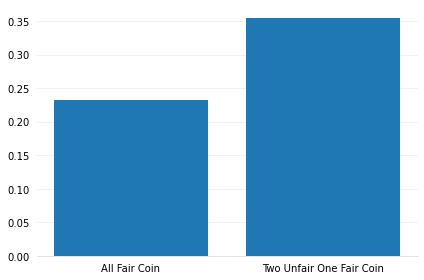

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from montecarlo import Die, Game, Analyzer

# Create fair coin
f_coin = Die(np.array(["H","T"]))

# Create unfair coin by setting the 'H' face to weight 5
u_coin = Die(np.array(["H","T"]))
u_coin.change_weight("H",5)

# Play game 1000 times with three fair coins
game = Game([f_coin,f_coin,f_coin])
game.play(1000)

# Calculate number of jackpots and relative frequency
analyzer = Analyzer(game)
num_jp = analyzer.jackpot()
rel_freq = num_jp / 1000

# Play game 1000 times with two unfair coin and one fair coin
game2 = Game([u_coin,u_coin,f_coin])
game2.play(1000)

# Calculate number of jackpots and relative frequency
analyzer2 = Analyzer(game2)
num_jp2 = analyzer2.jackpot()
rel_freq2 = num_jp2 / 1000

# Plot results
x = ["All Fair Coin", "Two Unfair One Fair Coin"]
y = [rel_freq, rel_freq2]
fig, ax = plt.subplots()

ax.bar(x,y)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()

## Scenario 2

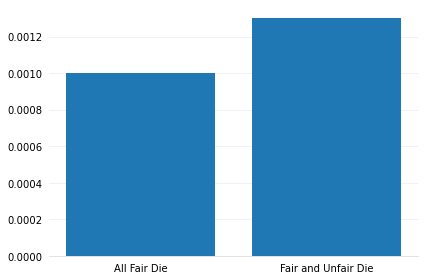

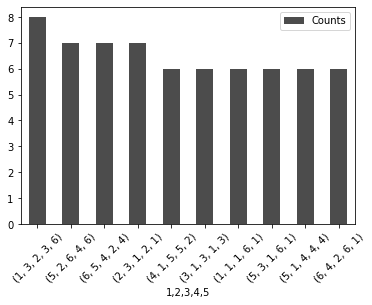

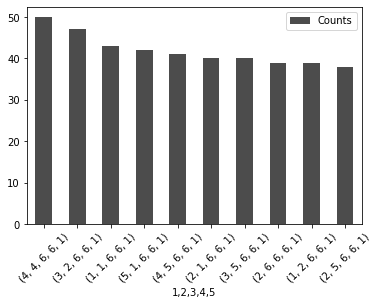

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from montecarlo import Die, Game, Analyzer

# Create fair dice and two unfair die (one unfair dice has weight 5 for face 6 (type 1) and the other unfair dice has weight 5 for face 1 (type 2))
f_die = Die(np.array([1,2,3,4,5,6]))
u_die_1 = Die(np.array([1,2,3,4,5,6]))
u_die_2 = Die(np.array([1,2,3,4,5,6])) 
u_die_1.change_weight(6,5)
u_die_2.change_weight(1,5)

# Play game 10000 times with all fair die
game = Game([f_die,f_die,f_die,f_die,f_die])
game.play(10000)

# Calculate number of jackpots and relative frequency
analyzer = Analyzer(game)
num_jp = analyzer.jackpot()
rel_freq = num_jp / 10000

# Play game 10000 times with two fair die, one unfair dice of type 1 and one unfair dice of type 2
game2 = Game([f_die,f_die,u_die_1,u_die_1,u_die_2])
game2.play(10000)

# Calculate number of jackpots and relative frequency
analyzer2 = Analyzer(game2)
num_jp2 = analyzer2.jackpot()
rel_freq2 = num_jp2 / 10000

# Plot results
x = ["All Fair Die", "Fair and Unfair Die"]
y = [rel_freq, rel_freq2]
fig, ax = plt.subplots()
ax.bar(x,y)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()

# Extract top 10 most frequency combos and plot
game_freqcombo = analyzer.combo()[:10]
game2_freqcombo = analyzer2.combo()[:10]
game_freqcombo.plot.bar(color='k',alpha=.7,rot=45);
game2_freqcombo.plot.bar(color='k',alpha=.7,rot=45);

## Scenario 3

Number of actual words generated: 3
Actual words: ['easel', 'cater', 'ceils']
Relative frequency of actual words: 0.003
Relative frequency of non-actual words: 0.997


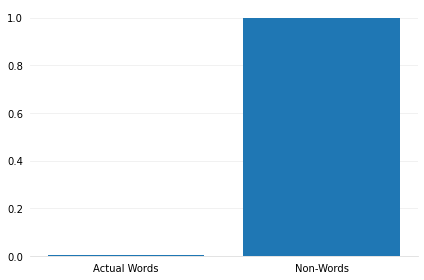

In [5]:
# Code blocks with outpuimport numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from montecarlo import Die, Game, Analyzer
import string
import os

# Set working directory
os.chdir('C:/Users/mk7kc/Documents/GitHub/DS5100_Final_Project/')

# Load in data with weights for the alphabet letters
lw = pd.read_csv('letter-freqs.csv',sep='\t', header = None)

# Create dice with the letters of the alphabet as the face values
die = Die(list(string.ascii_lowercase))

# Assign weights to the faces
for i in range(0,len(list(string.ascii_lowercase))):
    letter = list(string.ascii_lowercase)[i] 
    weight = lw[1][i] 
    die.change_weight(letter,weight)

# Create game with five dice and play 1000 times
game = Game([die,die,die,die,die])
game.play(1000)

# For all of the combos generated from the game, merge all the elements into one string  
combos = list()
for i in game.show().values:
    combo="".join(i)
    combos.append(combo)
    
# Read in data of five-letter words. This list has 5,757 five-letter words and was created by Dr. Knuth for his book, The Stanford GraphBase: A Platform for Combinatorial Computing
fiveletters = list(pd.read_csv('sgb-words.txt',header=None)[0])
actualwords = list()

# Check to see if any of the combos generated from the game are included in this list of actual words
actualwords.append([x for x in combos if x in fiveletters])
aw_count = len(actualwords[0])

# Calculate relative frequencies
rel_freq = aw_count/1000
rel_freq2 = (1000-aw_count)/1000


print(f"Number of actual words generated: {aw_count}")
print(f"Actual words: {actualwords[0]}")
print(f"Relative frequency of actual words: {rel_freq}")
print(f"Relative frequency of non-actual words: {rel_freq2}")

# Plot results
x = ["Actual Words", "Non-Words"]
y = [rel_freq, rel_freq2]
fig, ax = plt.subplots()
ax.bar(x,y)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.tight_layout()

# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [1]:
!ls -lRF -o

.:
total 127
drwxr-xr-x 1 mk7kc     0 Jul 13 17:35 __pycache__/
-rw-r--r-- 1 mk7kc   234 Jul 13 12:44 letter-freqs.csv
drwxr-xr-x 1 mk7kc     0 Jul 14 15:26 montecarlo/
drwxr-xr-x 1 mk7kc     0 Jul 14 12:38 montecarloPackage.egg-info/
-rw-r--r-- 1 mk7kc   136 Jul 14 09:37 montecarlo_demo.py
-rw-r--r-- 1 mk7kc 75977 Jul 14 15:26 montecarlo_report_scenarios.ipynb
-rw-r--r-- 1 mk7kc   431 Jul 14 09:51 setup.py
-rw-r--r-- 1 mk7kc 40299 Jul 13 13:35 sgb-words.txt

./__pycache__:
total 8
-rw-r--r-- 1 mk7kc 4675 Jul 13 17:35 montecarlo.cpython-39.pyc

./montecarlo:
total 26
-rw-r--r-- 1 mk7kc 1085 Jul 14 11:44 LICENSE
-rw-r--r-- 1 mk7kc  607 Jul 14 14:35 README.md
-rw-r--r-- 1 mk7kc   52 Jul 14 09:35 __init__.py
drwxr-xr-x 1 mk7kc    0 Jul 14 11:49 __pycache__/
-rw-r--r-- 1 mk7kc 7185 Jul 14 15:26 montecarlo.py
-rw-r--r-- 1 mk7kc  724 Jul 14 11:41 montecarlo_unitest_results.txt
-rw-r--r-- 1 mk7kc 3333 Jul 13 17:42 montecarlo_unittest.py

./montecarlo/__pycache__:
total 9
-rw-r--r-- 1 mk7kc  2

# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [7]:
!pip install .

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


Processing c:\users\mk7kc\documents\github\ds5100_final_project
  Created wheel for montecarloPackage: filename=montecarloPackage-1.0.0-py3-none-any.whl size=4734 sha256=d837d61b56a3f0ba623ed481ce20cf26beb3353a615201801f37c7741cf9596f
  Stored in directory: C:\Users\mk7kc\AppData\Local\Temp\pip-ephem-wheel-cache-pt0xq4__\wheels\45\4c\bf\875f033ec1591700e01b6e8c885e9875ac6d16765f46640d7c
Successfully built montecarloPackage
  Attempting uninstall: montecarloPackage
    Found existing installation: montecarloPackage 1.0.0
    Uninstalling montecarloPackage-1.0.0:
      Successfully uninstalled montecarloPackage-1.0.0
